# BRFSS survey predicting whether a person has diabites or not

https://www.cdc.gov/brfss/annual_data/annual_2024.html

need to download these files from the above page:
2024 BRFSS Codebook CDC 
2024 BRFSS Data (ASCII) 
download and unzip in your working file where the notebook is 

the data is not in a csv so we have to convert it, its a 'fixed width' meaning each var is seperate by a fixed width

In [40]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# PART 1 MAKING THE DATASET
uisng the codebook to find variables

diabetes: col: 149

age col: 1980-1981

income 

education

bmi (body mass index) col: 1994-1997



In [41]:
diabetes =[]
age = []
bmi = []
income = []
education = []
sex = []
general_health = []
smoking = []
drinking = []

with open("LLCP2024.ASC") as f:
    for line in f:
        #DIABETES
        value = line[148] #this has 1-9 posisble options we are only going to 7,9,blank are going to be missing values, 1 is yes, everything else is no
        if value == '1': #yes case
            diabetes.append(1)
        elif value in ['7','9',' ']: #missing value
            diabetes.append(np.nan)
        else: #no
            diabetes.append(0)
        #AGE

        value = line[1979:1981]
        age.append(int(value))
                   
        #BMI
        value = line[1993:1997]
        if value == '    ': #four blanks (missing value)
            bmi.append(np.nan)
        else: #we do have the value
            bmi.append(int(value)/100) #because it has two demcial places

        #INCOME
        value = line[203:205]
        if value == '  ':
            income.append(np.nan)
        elif value =='77':
            income.append(-1) #!the neg one indicats a unknown
        elif value == '99':
            income.append(-2) #! indicates a refused
        else:
            income.append(int(value))
        #SEX
        value = line[1975]
        sex.append(value)
        #EDUCATION
        value = line[186]
        if value == '9':
            education.append(np.nan)
        elif value == ' ':
            education.append(np.nan)
        else:
            education.append(value)
        #GENERAL HEALTH
        value = line[100]
        if value == '7' or value == '9' or value == '5':
            general_health.append(np.nan)
        else:
            general_health.append(value)
        #SMOKING
        value = line[2024:2027]
        if value == '   ' or int(value) > 40:
            smoking.append(np.nan)
        else:
            smoking.append(value)
        #DRINKING
        value = line[2056] #number of drinks per week         2048-2050       2052-2056
        if value == '9':
            drinking.append(np.nan)
        else:
            drinking.append(value)

        

df = pd.DataFrame(
    {
        'diabetes':diabetes,
        'age':age,
        'bmi':bmi,
        'income':income,
        'education':education,
        'sex':sex,
        'general_health':general_health,
        'drinking':drinking,
        'smoking':smoking
    }
)

In [42]:
df_small = df.sample(45000) #only using a small subset of the data

<Axes: >

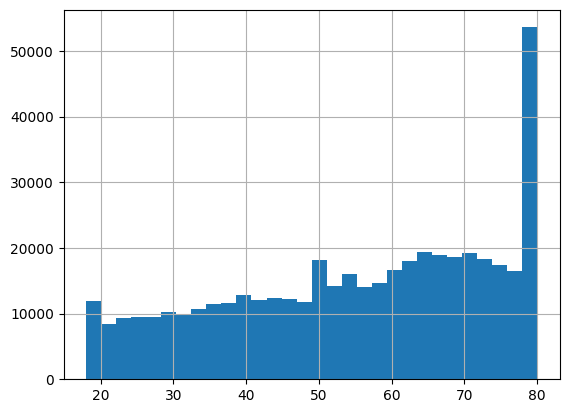

In [43]:
df.age.hist(bins=30) #much more older people in this set

<Axes: >

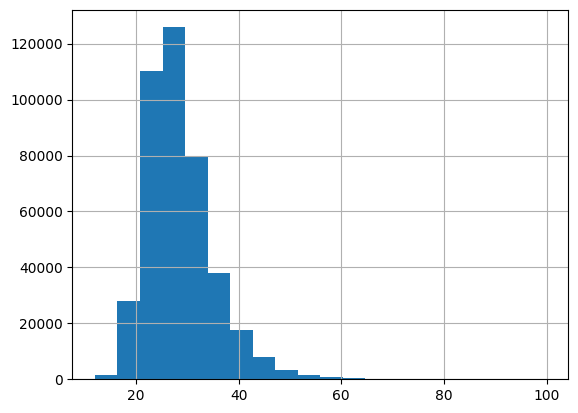

In [44]:
df.bmi.hist(bins=20)

In [45]:
df['drinking'].value_counts()

drinking
1    386812
2     24160
Name: count, dtype: int64

The above graphs serve to demonstrate that our dataset is imbalanced, and we are going to have to edit the threshold to make a good model.

# PART 2: Random forest model

In [46]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline #pipeline stuff
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
numerical_features = ['age','bmi']
catagorical_features = ['income','education','sex','general_health']

df.head()

,diabetes,age,bmi,income,education,sex,general_health,drinking,smoking
0,0.0,78,22.49,-2.0,4,2,3,1,NaN
1,0.0,80,25.83,11.0,6,1,1,1,020
2,0.0,59,22.53,-2.0,5,1,2,1,015
3,0.0,80,25.09,6.0,6,1,1,1,NaN
4,0.0,47,19.77,3.0,5,1,3,1,NaN


In [47]:
df.isna().sum()

diabetes            1034
age                    0
bmi                43037
income              9269
education           2363
sex                    0
general_health     23509
drinking           46698
smoking           308045
dtype: int64

As can be seen the dataset also contains many missing values, for some (the smoking for example) the nan simply indicates that they dont smoke. and more generally menas that that person was not asked this question

In [48]:

df.dropna(subset=['diabetes'],inplace=True)
df_small.dropna(subset=['diabetes'],inplace=True)


In [49]:
X_small = df_small.drop('diabetes',axis=1)
y_small = df_small['diabetes']
X = df.drop('diabetes',axis=1)
y = df['diabetes']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train_small,X_test_small,y_train_small,y_test_small = train_test_split(X_small,y_small)

### Making our model

In [50]:
from sklearn.model_selection import FixedThresholdClassifier
#and manuel test out thresholds
#use confusion matrix too

catagorical_features = ['income','education','sex','drinking','general_health']
numeric_features = ['age','bmi','smoking']

numeric_processor=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='constant', fill_value=0)), #fill value bacuse these were people who were not asked #! CHANGE AT SOME POINT
    ('scaler',StandardScaler())
    ])

categorical_processor=Pipeline(steps = [
    ('encoder',OneHotEncoder(handle_unknown='ignore',min_frequency=.01))
    ])

feature_processor = ColumnTransformer(transformers = [ 
    ('num',numeric_processor,numeric_features),
    ('cat',categorical_processor,catagorical_features)],
    )


In [51]:
from sklearn.ensemble import RandomForestClassifier
pipe_clf = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('clf',RandomForestClassifier())
    ])
pipe_clf

,steps,"[('feature_processor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Training our model
Here we are using a random search CV on the params of a random forest while using the average_precision (a metric that doesnt rely on the threshold so we can tune this later)

In [52]:
from sklearn.model_selection import RandomizedSearchCV

param_dic = {
    'clf__n_estimators': range(20,250),
    'clf__max_depth': range(2,10),
    'clf__min_samples_split': range(10,250),
    'clf__min_samples_leaf': range(5,250)
}
grid = RandomizedSearchCV(pipe_clf,
                          param_dic,
                          n_iter=50,
                          scoring='average_precision',
                          n_jobs=-1,
                          cv=5
)
grid.fit(X_train_small,y_train_small)

,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'clf__max_depth': range(2, 10), 'clf__min_samples_leaf': range(5, 250), 'clf__min_samples_split': range(10, 250), 'clf__n_estimators': range(20, 250)}"
,n_iter,50
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [53]:
#saving the classifer model as a pickle file 
import joblib
pipe_clf = grid.best_estimator_
joblib.dump(pipe_clf,'pipe_clf.pkl')


['pipe_clf.pkl']

In [54]:
pipe_clf = joblib.load('pipe_clf.pkl')

# PART 3: testing our model

In [55]:
#recall curve <-
from sklearn.metrics import precision_recall_curve
y_test_proba = pipe_clf.predict_proba(X_test_small)[:,1]

In [56]:
precision, recall, threshold = precision_recall_curve(y_test_small,y_test_proba)

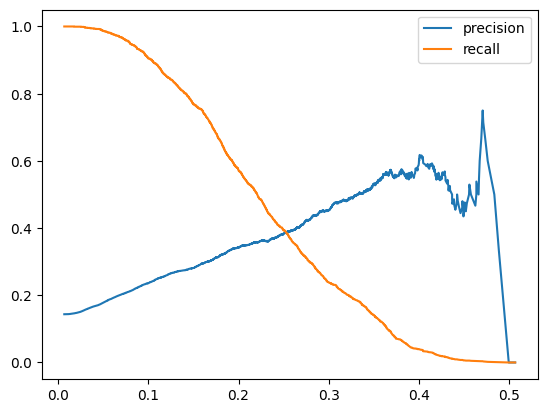

In [57]:
plt.plot(threshold,precision[0:-1],label='precision')
plt.plot(threshold,recall[0:-1],label='recall')
plt.legend()


### Setting the threshold
*(for now)*

In [58]:
threshold = .15
pipe_clf_threshold = FixedThresholdClassifier(pipe_clf,threshold=threshold) 

### Testing on some fake people and data

In [59]:
X_new = pd.DataFrame({
                      'age':[45,50,25,30],
                      'bmi':[30,35,20,37],
                      'income':[2,4,3,3],
                      'education':['4','4','3','4'],
                      'sex':['1','2','2','1'],
                      'general_health':['3','4','4','2'],
                      'drinking':['1','1','1','0'],
                      'smoking':['1','15','3','13']
                      })

In [60]:
pipe_clf_threshold.predict(X_new)

array([0., 1., 0., 0.])

And that is the prediction for the new dataset above

### Additional metrics for the model

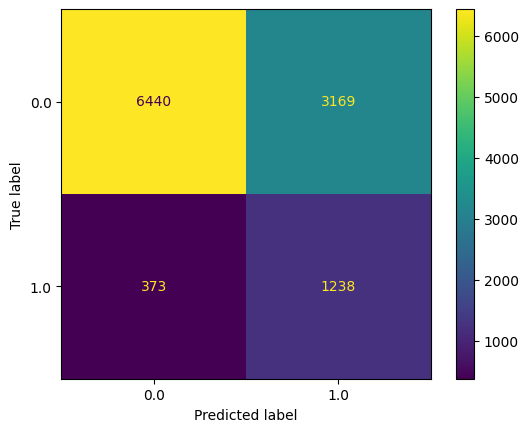

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred_small = pipe_clf_threshold.predict(X_test_small)
cm = confusion_matrix(y_test_small, y_test_pred_small, labels=pipe_clf_threshold.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe_clf_threshold.classes_).plot()


As can be seen the matrix tends to over predict overpredict that someone does have diabetes, however in the context of the data this is ok.

We would rather have some be diagnosed with diabetes and not have it, then for them to be told they dont have it when in reality they do.


In [62]:
from sklearn.metrics import r2_score
print(r2_score(y_test_small, y_test_pred_small))

-1.5672471474504133


This R^2 score is not ideal, and idicates that random predicts would, in theory, perform better then our model. However again in the context of the data, this random prediction (because of the imblanace in the data with so few actual examples of diabetics) would actaully be worse in the real world for the same reason as given above, and thusly our model given the real world, is alright

In [63]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_small, y_test_pred_small)

0.7193359034719351

Finally a roc score, which a score of .71 again given the context of the problem with a imbalance that we are accounting for, this is a decent enough score.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_small, y_test_pred_small)
print(accuracy) #accuracy score 

0.6843137254901961


Overall although the performance of the model is unideal, given the imbalance of the data, and the real world context for it, it turns out to be a alright model 